
# Categorize Expense Data

### Test the LLM

In [ ]:
#!pip -q install groq

In [1]:
from dotenv import find_dotenv, load_dotenv
_ = load_dotenv(find_dotenv())
import os


In [2]:
from groq import Groq

clientGroq = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)


In [ ]:
llm = Ollama(model="llama3")
llm.invoke("what country is the krabi province in?")

In [3]:
def get_completion(prompt, model= "llama3-70b-8192", clientGroq = clientGroq):
    messages = [{"role": "user", "content": prompt}]
    response = clientGroq.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0,
        max_tokens= 4000,
        top_p = 0.5
    )
    return response.choices[0].message.content

### Import Data

In [4]:
# Read the transactions_2022_2023.csv file 
import pandas as pd
df = pd.read_csv("transactions_2022_2023.csv")
df.head()

,Date,Name / Description,Expense/Income,Amount (EUR)
0,2023-12-30,Belastingdienst,Expense,9.96
1,2023-12-30,Tesco Breda,Expense,17.53
2,2023-12-30,Monthly Appartment Rent,Expense,451.00
3,2023-12-30,Vishandel Sier Amsterdam,Expense,12.46
4,2023-12-29,Selling Paintings,Income,13.63


In [5]:
# Get unique transactions in the Name / Description column
unique_transactions = df["Name / Description"].unique()
len(unique_transactions)

23

In [6]:
unique_transactions[1:10]

array(['Tesco Breda', 'Monthly Appartment Rent',
       'Vishandel Sier Amsterdam', 'Selling Paintings',
       'Spotify Ab By Adyen', 'Tk Maxx Amsterdam Da', 'Consulting',
       'Aidsfonds', 'Tls Bv Inz Ov-Chipkaart'], dtype=object)

### Categorize Transection with LLM

In [7]:
# Get index list
#https://stackoverflow.com/questions/47518609/for-loop-range-and-interval-how-to-include-last-step
def hop(start, stop, step):
    for i in range(start, stop, step):
        yield i
    yield stop

index_list = list(hop(0, len(unique_transactions), 5))
index_list

[0, 5, 10, 15, 20, 23]

In [9]:
def categorize_transactions(transaction_names):
    response = get_completion("Can you add an appropriate category to the following expenses. For example: Spotify AB by Adyen - Entertainment, Beta Boulders Ams Amsterdam Nld - Sport, etc.. Categories should be less than 4 words. " + transaction_names)
    response = response.split('\n')

    print(response)

    # Put in dataframe
    categories_df = pd.DataFrame({'Transaction vs category': response})
    categories_df[['Transaction', 'Category']] = categories_df['Transaction vs category'].str.split(' - ', expand=True)
    
    return categories_df

In [10]:
# Test out the function
categorize_transactions('ISS Catering Services De Meern, Taxi Utrecht, Etos AMSTERDAM NLD, Bistro Bar Amsterdam')

['Here are the categorized expenses:', '', '* ISS Catering Services De Meern - Food', '* Taxi Utrecht - Transport', '* Etos AMSTERDAM NLD - Health', '* Bistro Bar Amsterdam - Food']


,Transaction vs category,Transaction,Category
0,Here are the categorized expenses:,Here are the categorized expenses:,None
1,,,None
2,* ISS Catering Services De Meern - Food,* ISS Catering Services De Meern,Food
3,* Taxi Utrecht - Transport,* Taxi Utrecht,Transport
4,* Etos AMSTERDAM NLD - Health,* Etos AMSTERDAM NLD,Health
5,* Bistro Bar Amsterdam - Food,* Bistro Bar Amsterdam,Food


In [11]:
# Intialise the categories_df_all dataframe
categories_df_all = pd.DataFrame()

# Loop through the index_list
for i in range(0, len(index_list)-1):
    transaction_names = unique_transactions[index_list[i]:index_list[i+1]]
    transaction_names = ','.join(transaction_names)

    categories_df = categorize_transactions(transaction_names)
    categories_df_all = pd.concat([categories_df_all, categories_df], ignore_index=True)

['Here are the categorized expenses:', '', '* Belastingdienst - Taxes', '* Tesco Breda - Groceries', '* Monthly Appartment Rent - Rent', '* Vishandel Sier Amsterdam - Food', '* Selling Paintings - Income']
['Here are the categorized expenses:', '', '* Spotify Ab By Adyen - Entertainment', '* Tk Maxx Amsterdam Da - Shopping', '* Consulting - Work', '* Aidsfonds - Charity', '* Tls Bv Inz Ov-Chipkaart - Transportation']
['Here are the categorized expenses:', '', '* Etos Amsterdam - Health', '* Beta Boulders Ams Amsterdam Nld - Sport', '* Salary - Income', '* Bouldermuur Bv Amsterdam - Sport', '* Birtat Restaurant Amsterdam - Food']
['Here are the categorized expenses:', '', '* Spotify AB by Adyen - Entertainment', '* Beta Boulders Ams Amsterdam Nld - Sport', '* Freelancing - Work', '* Tikkie - Transfer', '* Blogging - Work', '* Taxi Utrecht - Transport', '* Apple Services - Tech']
['Here are the categorized expenses:', '', '* Spotify AB by Adyen - Entertainment', '* Beta Boulders Ams Amst

In [ ]:
categories_df_all

In [13]:
# Get unique categories in categories_df_all
unique_categories = categories_df_all["Category"].unique()
unique_categories

array(['Taxes', 'Groceries', 'Rent', 'Food', 'Income', 'Entertainment',
       'Shopping', 'Work', 'Charity', 'Transportation', 'Health', 'Sport',
       'Transfer', 'Transport', 'Tech', 'Fitness'], dtype=object)

In [12]:
# Drop NA values
categories_df_all = categories_df_all.dropna()

In [14]:
categories_df_all

,Transaction vs category,Transaction,Category
2,* Belastingdienst - Taxes,* Belastingdienst,Taxes
3,* Tesco Breda - Groceries,* Tesco Breda,Groceries
4,* Monthly Appartment Rent - Rent,* Monthly Appartment Rent,Rent
5,* Vishandel Sier Amsterdam - Food,* Vishandel Sier Amsterdam,Food
6,* Selling Paintings - Income,* Selling Paintings,Income
9,* Spotify Ab By Adyen - Entertainment,* Spotify Ab By Adyen,Entertainment
10,* Tk Maxx Amsterdam Da - Shopping,* Tk Maxx Amsterdam Da,Shopping
11,* Consulting - Work,* Consulting,Work
12,* Aidsfonds - Charity,* Aidsfonds,Charity
13,* Tls Bv Inz Ov-Chipkaart - Transportation,* Tls Bv Inz Ov-Chipkaart,Transportation


In [15]:
# Remove the numbering eg "1. " from Transaction column
categories_df_all['Transaction'] = categories_df_all['Transaction'].str.replace(r'\d+\.\s+', '', regex=True)
categories_df_all

,Transaction vs category,Transaction,Category
2,* Belastingdienst - Taxes,* Belastingdienst,Taxes
3,* Tesco Breda - Groceries,* Tesco Breda,Groceries
4,* Monthly Appartment Rent - Rent,* Monthly Appartment Rent,Rent
5,* Vishandel Sier Amsterdam - Food,* Vishandel Sier Amsterdam,Food
6,* Selling Paintings - Income,* Selling Paintings,Income
9,* Spotify Ab By Adyen - Entertainment,* Spotify Ab By Adyen,Entertainment
10,* Tk Maxx Amsterdam Da - Shopping,* Tk Maxx Amsterdam Da,Shopping
11,* Consulting - Work,* Consulting,Work
12,* Aidsfonds - Charity,* Aidsfonds,Charity
13,* Tls Bv Inz Ov-Chipkaart - Transportation,* Tls Bv Inz Ov-Chipkaart,Transportation


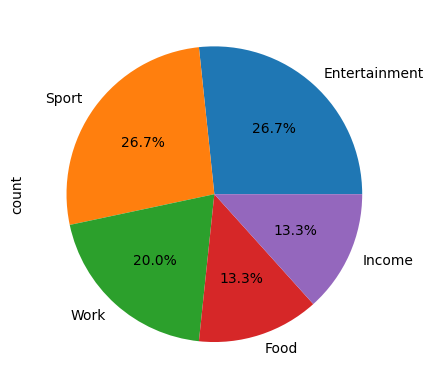

In [16]:
# Plot the top 5 categories in pie chart of the categories_df_all dataframe
categories_df_all['Category'].value_counts().head(5).plot.pie(autopct='%1.1f%%')

import matplotlib.pyplot as plt

